In [ ]:
!pip install wandb

In [ ]:
 !mkdir ~/.kaggle
 !mv kaggle.json ~/.kaggle
 !ls -a ~/.kaggle

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new
!unzip utkface-new.zip

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback

In [ ]:
wandb.init(project="age_Prediction")

In [ ]:
width = height = 224
batch_size = 32

In [ ]:
images = [] # X
ages = [] # Y

for image_name in os.listdir("/content/crop_part1"):
  age = int(image_name.split("_")[0])
  ages.append(age)

  image = cv2.imread(f"/content/crop_part1/{image_name}")
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (width, height))
  images.append(image)

In [ ]:
images = pd.Series(images, name="Images")
ages = pd.Series(ages, name="Ages")

dataframe = pd.concat([images, ages], axis=1)
dataframe.head()

,Images,Ages
0,"[[[36, 17, 11], [36, 17, 11], [37, 17, 10], [3...",53
1,"[[[69, 53, 40], [66, 50, 37], [62, 46, 33], [5...",16
2,"[[[146, 102, 67], [147, 104, 68], [149, 105, 7...",88
3,"[[[158, 120, 71], [144, 106, 58], [121, 84, 38...",18
4,"[[[234, 206, 194], [234, 206, 194], [234, 206,...",56


53


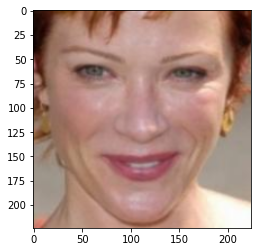

In [ ]:
print(dataframe["Ages"][0])
plt.imshow(dataframe["Images"][0])
plt.show()

16


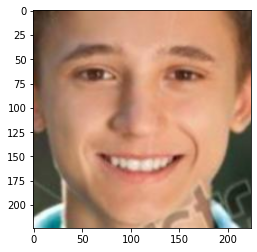

In [ ]:
print(dataframe["Ages"][1])
plt.imshow(dataframe["Images"][1])
plt.show()

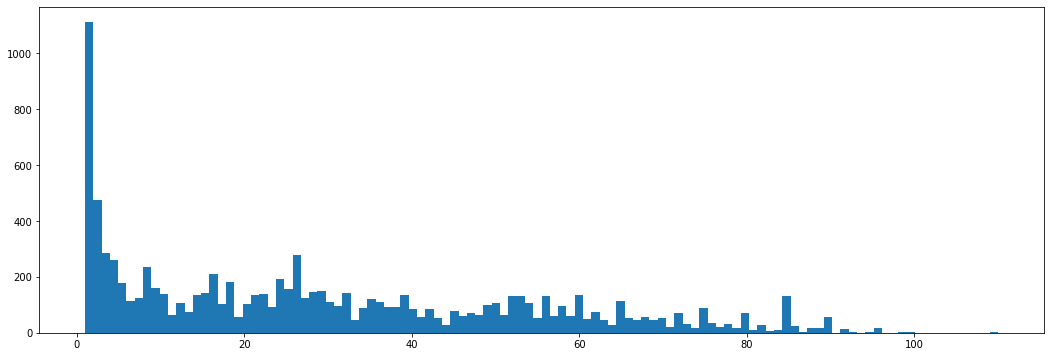

In [ ]:
plt.figure(figsize=(18, 6))
plt.hist(dataframe["Ages"], bins=dataframe["Ages"].max())
plt.show()

In [ ]:
under_4 = dataframe[dataframe["Ages"] <= 4]
under_4_new = under_4.sample(frac=0.3)

up_4 = dataframe[dataframe["Ages"] > 4]

dataframe = pd.concat([under_4_new, up_4], axis=0)

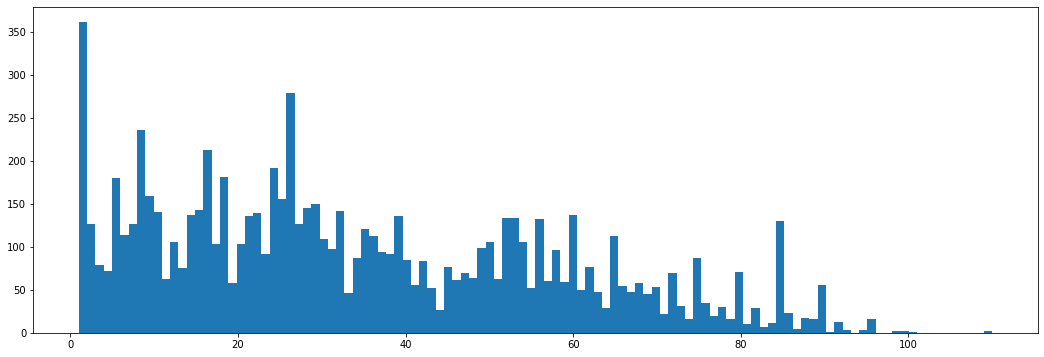

In [ ]:
plt.figure(figsize=(18, 6))
plt.hist(dataframe["Ages"], bins=dataframe["Ages"].max())
plt.show()

In [ ]:
dataframe = dataframe[dataframe["Ages"] < 80]

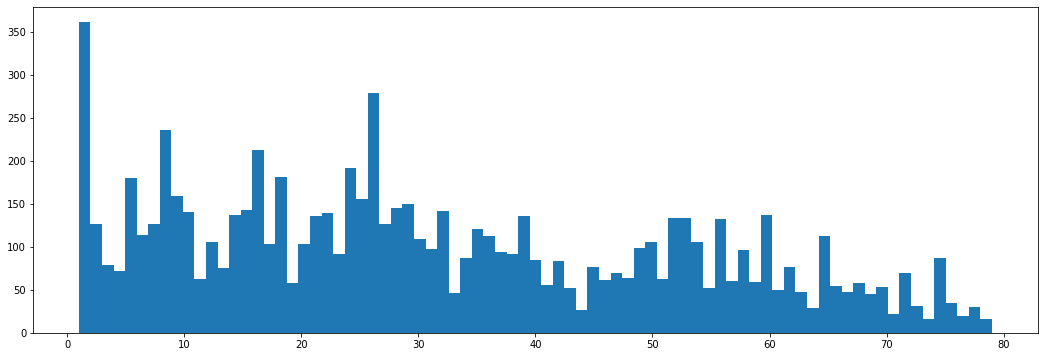

In [ ]:
plt.figure(figsize=(18, 6))
plt.hist(dataframe["Ages"], bins=dataframe["Ages"].max())
plt.show()

In [ ]:
X = np.array(dataframe["Images"].values.tolist())
Y = np.array(dataframe["Ages"].values.tolist())

In [ ]:
print(X.shape)
print(Y.shape)

(7871, 224, 224, 3)
(7871,)


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(6296, 224, 224, 3)
(6296,)
(1575, 224, 224, 3)
(1575,)


In [ ]:
idg = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    brightness_range = (0.7, 1.3)
)

train_data = idg.flow(X_train, Y_train, batch_size = batch_size)
val_data = idg.flow(X_val, Y_val, batch_size = batch_size)

### Train

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    include_top = False,
    weights = "imagenet",
    input_shape = (width, height, 3),
    pooling = "avg"
)

In [ ]:
for layer in base_model.layers[:-2]:
  layer.trainable = False

In [ ]:
model = tf.keras.Sequential([
  base_model,
  Dropout(0.5),
  Dense(512, activation="relu"),
  Dropout(0.3),
  Dense(1, activation="linear")
])

In [ ]:
config = wandb.config
config.learning_rate = 0.001

In [ ]:
model.compile(optimizer=Adam(learning_rate=config.learning_rate),
              loss=tf.keras.losses.mse)

In [ ]:
model.fit(train_data, validation_data=val_data, epochs=27, callbacks=[WandbCallback()])

In [ ]:
model.evaluate(val_data)

50/50 [==============================] - 6s 110ms/step - loss: 133.4948


133.49476623535156

### inference

In [ ]:
def inference(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.show()
  img = img / 255.0
  img = cv2.resize(img, (width, height))
  img = img.reshape(1, width, height, 3)
  pred = model.predict(img)
  pred = pred[0, 0]
  return pred

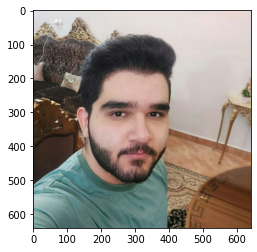

43.41604

In [ ]:
inference("/content/my_photo_1.jpg")

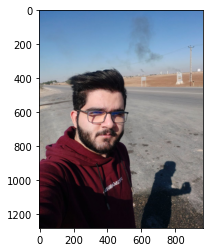

24.398565

In [ ]:
inference("/content/my_photo_2.jpg")

### save the model

In [ ]:
model.save("/content/drive/MyDrive/Age_prediction/Age_prediction.h5")